In [1]:
%pylab inline --no-import-all
from scipy.stats import chi2, norm

Populating the interactive namespace from numpy and matplotlib


In [2]:
import george
from george.kernels import ExpSquaredKernel

In [3]:
n_scan_points = 100
x = np.linspace(0,100,n_scan_points)

In [4]:
n_dist = 10
width = 5
mixture_means = np.random.uniform(3*width,100-3*width,n_dist)

In [5]:
def pdf(x):
    ret = 0*x
    for i,xx in enumerate(x):
        ret[i] = np.sum(norm.pdf(xx,mixture_means, width))
    return ret/n_dist

def cdf(x):
    ret = 0*x
    for i,xx in enumerate(x):
        ret[i] = np.sum(norm.cdf(xx,mixture_means, width))
    return ret/n_dist

In [6]:
def generate(n):
    n_ceil = np.ceil(1.*n/n_dist)
    ret = np.zeros(n_ceil*n_dist)
    for i, mu in enumerate(mixture_means):
        ret[i*n_ceil : (i+1)*n_ceil] = norm.rvs(loc=mu, scale=width,size=n_ceil)
    return ret[0:n]

In [7]:
points = np.sort(generate(500))

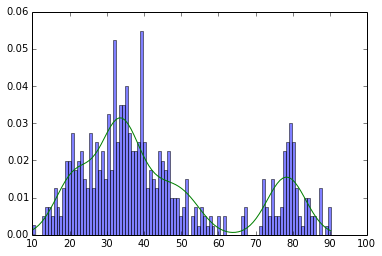

In [8]:
bins, edges, _ = plt.hist(points, bins=100, normed=True, alpha=.5)
plt.plot(edges,pdf(edges))

In [9]:
y = np.linspace(0,1,points.size)
#binomial errors for the emperical cdf
yerr = np.sqrt(y*(1.-y)/y.size) 

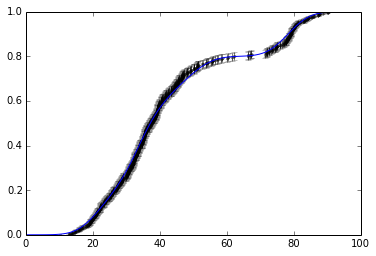

In [10]:
#plt.scatter(points,y,alpha=0.3)
plt.errorbar(points, y, yerr, alpha=0.5,fmt=".k")
plt.plot(x,cdf(x))

In [11]:
dy = (y-np.roll(y,1))/(points-np.roll(points,1))
dy[0]=0.
dyerr = np.sqrt(yerr**2 + np.roll(yerr,1)**2)/(points-np.roll(points,1)) #neglects correlations
dyerr = yerr/(points-np.roll(points,1)) #needs more thought
dyerr[0]=0.

In [12]:
temp = cdf(points)
tempdy = (temp-np.roll(temp,1))/(points-np.roll(points,1))
tempdy[0]=0

problem... want to do log-Gaussian process for positivity, but noise makes observations go negative.

want ln_pred ~GP, pred ~ exp(GP) + noise

In [35]:
log_dy = np.log(dy)
log_dy[0]=log_dy[1]

log_dyerr = np.log(dyerr)
log_dyerr[0]=log_dyerr[1]
log_dyerr[-1]=log_dyerr[-2]


log_true_dy = np.log(np.abs(tempdy))
log_true_dy[0]=log_true_dy[1]

/Library/Python/2.7/site-packages/IPython/kernel/__main__.py:1: RuntimeWarning: divide by zero encountered in log
  if __name__ == '__main__':
/Library/Python/2.7/site-packages/IPython/kernel/__main__.py:4: RuntimeWarning: divide by zero encountered in log
/Library/Python/2.7/site-packages/IPython/kernel/__main__.py:9: RuntimeWarning: divide by zero encountered in log


In [58]:
length_scale_of_correaltion=70.
kernel_d = ExpSquaredKernel(length_scale_of_correaltion, ndim=1)
gp_d = george.GP(kernel_d, mean=np.mean(log_dy), solver=george.HODLRSolver) #faster
#gp_d.compute(points,log_dyerr)
gp_d.compute(points, yerr=np.mean(log_dyerr))
pred_log_dy, _ = gp_d.predict(log_dy,x)
print np.mean(log_dy), np.mean(log_dyerr)

-3.49017600035 -1.38750894045


(-5, 0)

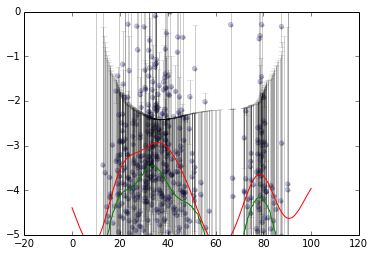

In [59]:
plt.errorbar(points,log_dy, log_dyerr, fmt=".k", alpha=0.2)
plt.scatter(points,log_dy,alpha=0.2)
plt.plot(points,log_true_dy, c='g')
plt.plot(x,pred_log_dy, c='r')
plt.ylim(-5,0)

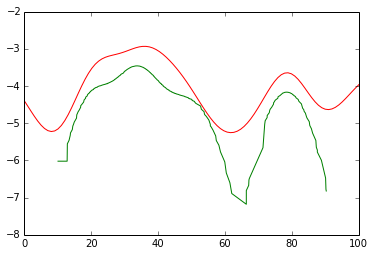

In [60]:
pred_d = np.exp(pred_log_dy)
#plt.plot(points,dy)
#plt.plot(points,tempdy)
plt.plot(points,log_true_dy, c='g')
plt.plot(x,pred_log_dy, c='r')

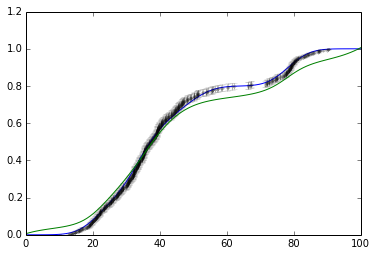

In [63]:
pred = np.cumsum(pred_d)
#now rescale and shift
#pred = (curve(x[-1])-curve(x[0]))*(pred[-1]-pred[0]) + curve(x[0])
pred = pred*(y[-1]-y[0])/(pred[-1]-pred[0]) + y[0]

plt.plot(x,cdf(x))
#plt.scatter(points,y)
plt.errorbar(points,y, yerr, fmt=".k", alpha=0.2)
plt.plot(x,pred)